In [1]:
#questions:



In [1]:
#import packages
import numpy as np
import csv
from imageio import imread
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import scipy.linalg as scl
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Function definitions

In [2]:
"""
This is an "uglified" version of the FrankeFunction, to minimize use of costly functions like divisions and powers.
It takes as input parameters a meshgrid of coordinates in the x and y direction.
"""
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [3]:
"""
This function creates the Model Matrix, usually dubbed X, for regression analysis.
It takes as input parameters a meshgrid of coordinates in the x and y direction, 
and the polynomial degree P that you wish to fit.

The order of columns is different from the one scikit learn creates, so take care to use the same model-creator when
comparing scikit and this code.

The ordering this function creates is: x^0y^0, x^1y^0, x^2y^0, x^0y^1, x^1y^1, x^0y^2 for a 2nd order polynomial.
"""
def Model(x,y,P): 
    m = len(x)*len(y) # number of equations
    t = sum(range(P+2)) # number of terms in polynomial
    X = np.zeros((m,t)) # Model matrix
    a = np.matrix.flatten(x)
    b = np.matrix.flatten(y)
    c = 0 #counter
    for i in range(P+1):
        for j in range(P+1-i):
            X[:,c] = a**j*b**i
            c +=1
    return X

In [4]:
def ols_svd(X:np.ndarray, z:np.ndarray ,_lambda,method='ols')->np.ndarray:
    u, s, v = scl.svd(X)
    if method=='ols':
        return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ z
    if method=='ridge':
        return (v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ z)/(1+_lambda)

In [5]:
def VarOLS_betas(X, sigma):
    covar = np.linalg.inv(X.T.dot(X))
    vari = np.diagonal(covar)
    return vari*(sigma**2)

In [6]:
def VarRidge_betas(X,_lambda,sigma):
    XX = X.T@X
    invers = np.linalg.inv(XX+_lambda*np.eye(len(XX)))
    return np.diagonal(invers)*(sigma**2)

In [7]:
def NoResampling(X,z_n,_lambda,method='ols'):
    if method =='ols':
        beta = np.linalg.inv(X.T.dot(X)+_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)
    elif method == 'svd':
        beta = np.ndarray(ols_svd(X,z_n))
    else:
        print("No method selected, defaulting to OLS")
        beta = np.linalg.inv(X.T.dot(X)+_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)
    ztilde = X @ beta
    mse= np.sum((z_n-z_tilde)**2)/np.size(ztilde)
    r2 = 1-np.sum((z_n-ztilde)**2)/np.sum((z_n-np.mean(z_n))**2)
#     return MSE(z_n,ztilde), R2(z_n,ztilde), beta, VarOLS_betas(X,0.)#,ztilde
    return mse,r2,beta,VarOLS_betas(X,0.)

In [8]:
"""
Standard mean squared error calculator, inputs are measured/real data and regression model values.
"""
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [9]:
"""
Just a standard R2 score calculator, taking the measured/real data as the first input, and the values the 
regression model finds as the second input
"""
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

In [10]:
def Bias(y_data, y_model):
    n = np.size(y_data)
    return np.sum((y_data-np.mean(y_model))**2)/n

In [11]:
def LatexPrinter(betas,variances):
    for i in range(len(betas)-1):#%.2f
        print("$\\beta_{{{}}}$ & {} & {} \\\ ".format(i,round(betas[i],7),round(variances[i],7)))
    print("$\\beta_{{{}}}$ & {} & {} \\\ \\hline".format(i+1,round(betas[i+1],7),round(variances[i+1],7)))

In [12]:
def Shuffler(X,z_n):
#     np.random.seed(1234)
    n = len(X[0,:])
    combi = np.c_[X,z_n] #combine
    np.random.shuffle(combi) #shuffle
    X, z_n = combi[:,:n], combi[:,n] #split
    return X, z_n

In [13]:
def kSplitter(X,z,k):
    k = int(np.math.ceil((1./k)*len(X)))
    n,m = np.shape(X)
    ind = np.arange(0,n,k)
    for i in ind:
        X_test, z_test = X[i:(i+k),:],z[i:(i+k)]
        if i ==0:
            X_train,z_train = X[i+k:,:],z[i+k:]
        elif i ==(n-k):
            X_train,z_train = X[:i,:],z[:i]
        else:
            X_train = np.vstack([X[:i,:],X[i+k:,:]])
            z_train = np.hstack([z[:i],z[i+k:]])
        yield X_train, X_test, z_train, z_test

In [39]:
def kFolds(X,z_n,k,_lambda,method,sigma):
    #shuffle data before doing the kFold
    X_s,z_n_s = Shuffler(X,z_n)

    #initialize values
    err=[]
    bi =[]
    vari=[]
#     test_size = int(len(z_n)*(1./k))
    test_size = int(np.math.ceil((1./k)*len(X)))
    train_size= len(z_n)-test_size
    z_test_pred=np.empty((test_size,k))
    z_train_pred=np.empty((train_size,k))

    c=0
    mse_test_eval = 0.
    mse_train_eval=0.
    
    r2_test_eval = 0.
    r2_train_eval=0.
    betas=[]
    beta_variances=[]
    for X_train_, X_test_, z_train_, z_test_ in kSplitter(X_s,z_n_s,k):
        #center data here        
        X_train = X_train_ - np.mean(X_train_,axis=0)
        z_train = z_train_ - np.mean(z_train_)
        X_test  = X_test_  - np.mean(X_train_,axis=0)
        z_test  = z_test_  - np.mean(z_train_)
        X_train = np.delete(X_train,0,1)
        X_test = np.delete(X_test,0,1)
        # find parameters
        if method=='ols':
            beta = ols_svd(X_train,z_train,0.,'ols')
            beta_var = VarOLS_betas(X_train,sigma)
        if method=='ridge':
            beta = ols_svd(X_train,z_train,_lambda,'ridge')
            beta_var=VarRidge_betas(X_train,_lambda,sigma)
        if method =='LASSO':
            lassoing = Lasso(alpha=_lambda,fit_intercept=False, tol = 0.01, max_iter=100000)
            lassoing.fit(X_train,z_train)
            beta=lassoing.coef_
            beta_var=0.
        betas.append(beta)
        beta_variances.append(beta_var)
        
        # add centered stuff back
        z_test_pred[:,c] = X_test@beta+np.mean(z_train_)
        z_train_pred[:,c] = X_train@beta+np.mean(z_train_)

        mse_test_eval += np.mean((z_test_ - z_test_pred[:,c])**2,axis=0,keepdims=True)
        mse_train_eval += np.mean((z_train_ - z_train_pred[:,c])**2,axis=0,keepdims=True)
        
        r2_test_eval +=1-np.sum((z_test_-z_test_pred[:,c])**2,axis=0,keepdims=True)/np.sum((z_test_-np.mean(z_test_))**2,axis=0,keepdims=True)
        r2_train_eval +=1-np.sum((z_train_-z_train_pred[:,c])**2,axis=0,keepdims=True)/np.sum((z_train_-np.mean(z_train_))**2,axis=0,keepdims=True)
        c+=1
    return mse_test_eval/k, mse_train_eval/k, r2_test_eval/k, r2_train_eval/k, np.mean(betas,axis=0),np.mean(beta_variances,axis=0)

# plot over various noises

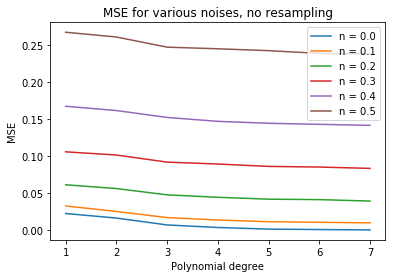

In [141]:
#Create random variables/predictors
N = 30 #number of points along x and y axes
n=10

# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

degrees=np.arange(1,20)
noises=np.linspace(0,0.5,6)
mse_ols_for_plot_out = []
MSE_RE = np.zeros((len(noises),len(degrees)))
for j,noi in enumerate(noises):
    Noise=noi*np.random.randn(N,N)
    z_noise = z+Noise
    z_n = np.matrix.flatten(z_noise)
    for i,deg in enumerate(degrees):
        X=Model(x,y,deg)
        mse_ols_no_re, r2_ols_no_re,beta_ols_no_re,beta_var_ols_no_re = NoResampling(X,z_n,0.,'ols')
        MSE_RE[j][i]=mse_ols_no_re
max_plot_degree=7
plt.figure()
for i in range(len(noises)):
    plt.plot(degrees[:max_plot_degree],MSE_RE[i,:max_plot_degree],label='n = {}'.format(round(noises[i],1)))
plt.xlabel('Polynomial degree')
plt.xticks(degrees[:max_plot_degree])
plt.ylabel('MSE')
plt.legend()
plt.title('MSE for various noises, no resampling')
plt.show()

# create plots of MSE/variance for all methods (one lambda for each regularization method)

In [400]:
#Create random variables/predictors
N = 20 #number of points along x and y axes
n=10

# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1 #might wanna make a function for this to loop over weights?
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_noise = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_noise)

#number of folds for crossvalidation
k=5

#polydegrees to run
degrees=np.arange(1,7)

_lambda=0.013530477745798061  #found from running over many lambda and polynomial degrees(for a small dataset, N=10)
_lambda_lasso=1.4563484775012445*10**-5 #as for ridge
#test vals
mse_ols_test =[]
mse_ridge_test=[]
mse_lasso_test=[]
r2_ols_test=[]
r2_ridge_test=[]
r2_lasso_test=[]

#train vals
mse_ols_train =[]
mse_ridge_train=[]
mse_lasso_train=[]
r2_ols_train=[]
r2_ridge_train=[]
r2_lasso_train=[]

#beta values
beta_ols=[]
beta_variance_ols=[]
beta_ridge=[]
beta_variance_ridge=[]
beta_LASSO = []
for deg in degrees:
    print("Computing polynomial degree {}".format(deg))
    X = Model(x,y,deg)

    mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances = kFolds(X,z_n,k,_lambda,'ols',noise_weight)
    mse_ols_test.append(mse_te)
    mse_ols_train.append(mse_tr)
    r2_ols_test.append(r2_te)
    r2_ols_train.append(r2_tr)
    beta_ols.append(betas)
    beta_variance_ols.append(beta_variances)

#     mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances  = kFolds(X,z_n,k,_lambda,'ridge',noise_weight)
#     mse_ridge_test.append(mse_te)
#     mse_ridge_train.append(mse_tr)
#     r2_ridge_test.append(r2_te)
#     r2_ridge_train.append(r2_tr)
#     beta_ridge.append(betas)
#     beta_variance_ridge.append(beta_variances)
    
#     mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances  = kFolds(X,z_n,k,_lambda_lasso,'LASSO',noise_weight)
#     mse_lasso_test.append(mse_te)
#     mse_lasso_train.append(mse_tr)
#     r2_lasso_test.append(r2_te)
#     r2_lasso_train.append(r2_tr)
#     beta_LASSO.append(betas)

Computing polynomial degree 1
Computing polynomial degree 2
Computing polynomial degree 3
Computing polynomial degree 4
Computing polynomial degree 5
Computing polynomial degree 6


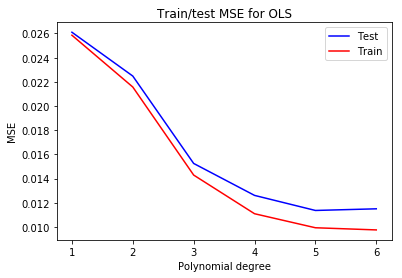

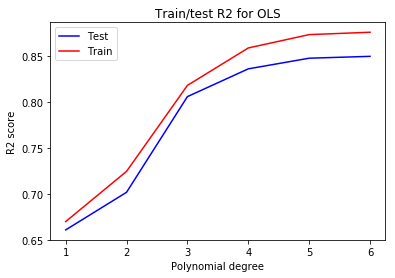

In [401]:
"""
Note that the reason for not automating the plotting for each fuction/scoring 
is that we might want to personalize each plot.
"""
# plt.figure()
# plt.plot(degrees,mse_ols_test,'b',label='OLS')
# plt.plot(degrees,mse_ridge_test,'r',label='Ridge, l={}'.format(_lambda))
# plt.plot(degrees,mse_lasso_test,'k',label='LASSO, l={}'.format(_lambda_lasso))
# plt.legend()
# plt.xlabel('Polynomial degree')
# plt.xticks(degrees)
# plt.ylabel('MSE')
# plt.title('Test MSE for all methods')
# plt.show()

# plt.figure()
# plt.plot(degrees,mse_ols_train,'b',label='OLS')
# plt.plot(degrees,mse_ridge_train,'r',label='Ridge, l={}'.format(_lambda))
# plt.plot(degrees,mse_lasso_train,'k',label='LASSO, l={}'.format(_lambda_lasso))
# plt.legend()
# plt.xlabel('Polynomial degree')
# plt.xticks(degrees)
# plt.ylabel('MSE')
# plt.title('Train MSE for all methods')
# plt.show()

# plt.figure()
# plt.plot(degrees,r2_ols_test,'b',label='OLS')
# plt.plot(degrees,r2_ridge_test,'r',label='Ridge, l={}'.format(_lambda))
# plt.plot(degrees,r2_lasso_test,'k',label='LASSO, l={}'.format(_lambda_lasso))
# plt.legend()
# plt.xlabel('Polynomial degree')
# plt.xticks(degrees)
# plt.ylabel('R2 score')
# plt.title('Test R2 for all methods')
# plt.show()

# plt.figure()
# plt.plot(degrees,r2_ols_train,'b',label='OLS')
# plt.plot(degrees,r2_ridge_train,'r',label='Ridge, l={}'.format(_lambda))
# plt.plot(degrees,r2_lasso_train,'k',label='LASSO, l={}'.format(_lambda_lasso))
# plt.legend()
# plt.xlabel('Polynomial degree')
# plt.xticks(degrees)
# plt.ylabel('R2 score')
# plt.title('Train R2 for all methods')
# plt.show()

################################################################
plt.figure()
plt.plot(degrees,mse_ols_test,'b',label='Test')
plt.plot(degrees,mse_ols_train,'r',label='Train')
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('MSE')
plt.title('Train/test MSE for OLS')
plt.show()

plt.figure()
plt.plot(degrees,r2_ols_test,'b',label='Test')
plt.plot(degrees,r2_ols_train,'r',label='Train')
plt.legend()
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.ylabel('R2 score')
plt.title('Train/test R2 for OLS')
plt.show()
##################################################################
# plt.figure()
# plt.plot(degrees,mse_ridge_test,'b',label='Test')
# plt.plot(degrees,mse_ridge_train,'r',label='Train')
# plt.legend()
# plt.xlabel('Polynomial degree')
# plt.xticks(degrees)
# plt.ylabel('MSE')
# plt.title('Train/test MSE for Ridge, l={}'.format(_lambda))
# plt.show()

# plt.figure()
# plt.plot(degrees,r2_ridge_test,'b',label='Test')
# plt.plot(degrees,r2_ridge_train,'r',label='Train')
# plt.legend()
# plt.xlabel('Polynomial degree')
# plt.xticks(degrees)
# plt.ylabel('R2 score')
# plt.title('Train/test R2 for Ridge, l={}'.format(_lambda))
# plt.show()
#####################################################################
# plt.figure()
# plt.plot(degrees,mse_lasso_test,'b',label='Test')
# plt.plot(degrees,mse_lasso_train,'r',label='Train')
# plt.legend()
# plt.xlabel('Polynomial degree')
# plt.xticks(degrees)
# plt.ylabel('MSE')
# plt.title('Train/test MSE for LASSO, l={}'.format(_lambda_lasso))
# plt.show()

# plt.figure()
# plt.plot(degrees,r2_lasso_test,'b',label='Test')
# plt.plot(degrees,r2_lasso_train,'r',label='Train')
# plt.legend()
# plt.xlabel('Polynomial degree')
# plt.xticks(degrees)
# plt.ylabel('R2 score')
# plt.title('Train/test R2 for LASSO, l={}'.format(_lambda_lasso))
# plt.show()

# create confidence interval for resampling, ols

In [174]:
poly_degrees=np.arange(1,6)

print("With k-fold resampling")
for i in poly_degrees:
    print("---------------")
    print("\\begin{table}[]")
    print("\\centering")
    print("\\caption{{OLS method, polynomial degree {}}}".format(i))
    print("\\begin{tabular}{|c|cc|}")
    print("\\hline")
    print("\\multicolumn{1}{|l|}{\\multirow{2}{*}{Coefficient}} & \\multicolumn{2}{l|}{Confidence interval = $\\beta_{mean}$ $\\pm$ 2*$\\sigma_{mean}$} \\\\")
    print("\\multicolumn{1}{|l|}{}  & $\\beta_{mean}$                        & $\\sigma_{mean}$                                         \\\\ \hline")   
    Betas_OLS = beta_ols[i-1]
    Beta_Variances_OLS = beta_variance_ols[i-1]
    LatexPrinter(Betas_OLS,Beta_Variances_OLS)
    print("\\end{tabular}")
    print("\\label{{tab:OLS_no.{}}}".format(i))
    print("\\end{table}")

With k-fold resampling
---------------
\begin{table}[]
\centering
\caption{OLS method, polynomial degree 1}
\begin{tabular}{|c|cc|}
\hline
\multicolumn{1}{|l|}{\multirow{2}{*}{Coefficient}} & \multicolumn{2}{l|}{Confidence interval = $\beta_{mean}$ $\pm$ 2*$\sigma_{mean}$} \\
\multicolumn{1}{|l|}{}  & $\beta_{mean}$                        & $\sigma_{mean}$                                         \\ \hline
$\beta_{0}$ & -0.8120637 & 0.0016981 \\ 
$\beta_{1}$ & -0.5090383 & 0.0026968 \\ \hline
\end{tabular}
\label{tab:OLS_no.1}
\end{table}
---------------
\begin{table}[]
\centering
\caption{OLS method, polynomial degree 2}
\begin{tabular}{|c|cc|}
\hline
\multicolumn{1}{|l|}{\multirow{2}{*}{Coefficient}} & \multicolumn{2}{l|}{Confidence interval = $\beta_{mean}$ $\pm$ 2*$\sigma_{mean}$} \\
\multicolumn{1}{|l|}{}  & $\beta_{mean}$                        & $\sigma_{mean}$                                         \\ \hline
$\beta_{0}$ & -2.2701904 & 0.038767 \\ 
$\beta_{1}$ & 0.9549401 & 0.02

# create confidence interval for resampling, Ridge

In [225]:
poly_degrees=np.arange(1,6)
print("For k-fold resapmling")
for i in poly_degrees:
    print("---------------")
    print("\\begin{table}[]")
    print("\\centering")
    print("\\caption{{Ridge method, polynomial degree {}}}".format(i))
    print("\\begin{tabular}{|c|cc|}")
    print("\\hline")
    print("\\multicolumn{1}{|l|}{\\multirow{2}{*}{Coefficient}} & \\multicolumn{2}{l|}{Confidence interval = $\\beta_{mean}$ $\\pm$ 2*$\\sigma_{mean}$} \\\\")
    print("\\multicolumn{1}{|l|}{}  & $\\beta_{mean}$                        & $\\sigma_{mean}$                                        \\\\ \hline")   
    Betas_Ridge = beta_ridge[i-1]
    print(type(Betas_Ridge))
    Beta_Variances_Ridge = beta_variance_ridge[i-1]
    print(type(Beta_Variances_Ridge))

    LatexPrinter(Betas_Ridge,Beta_Variances_Ridge)
    print("\\end{tabular}")
    print("\\label{{tab:Ridge_no.{}}}".format(i))
    print("\\end{table}")

For k-fold resapmling
---------------
\begin{table}[]
\centering
\caption{Ridge method, polynomial degree 1}
\begin{tabular}{|c|cc|}
\hline
\multicolumn{1}{|l|}{\multirow{2}{*}{Coefficient}} & \multicolumn{2}{l|}{Confidence interval = $\beta_{mean}$ $\pm$ 2*$\sigma_{mean}$} \\
\multicolumn{1}{|l|}{}  & $\beta_{mean}$                        & $\sigma_{mean}$                                        \\ \hline
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
$\beta_{0}$ & -0.8012228 & 0.0016942 \\ 
$\beta_{1}$ & -0.5022427 & 0.0026869 \\ \hline
\end{tabular}
\label{tab:Ridge_no.1}
\end{table}
---------------
\begin{table}[]
\centering
\caption{Ridge method, polynomial degree 2}
\begin{tabular}{|c|cc|}
\hline
\multicolumn{1}{|l|}{\multirow{2}{*}{Coefficient}} & \multicolumn{2}{l|}{Confidence interval = $\beta_{mean}$ $\pm$ 2*$\sigma_{mean}$} \\
\multicolumn{1}{|l|}{}  & $\beta_{mean}$                        & $\sigma_{mean}$                                        \\ \hline
<class 'numpy.ndarr

# create confidence interval for resampling, LASSO

In [276]:
    this is just an indented line so you don't accidentaly start running this very slow loop. 
#     comment out the above if you've got time
_lambda_lasso=1.4563484775012445*(10**-5)
n_iterations=100
poly_deg_=5
beta_LASSO =np.zeros((len(degrees),n_iterations,sum(range(poly_deg_+2))-1))

k=5
for j,deg in enumerate(degrees):
    print("Calculating polynomial degree {}".format(j+1))
    X = Model(x,y,deg)
    for i in range(n_iterations):
        X_s,z_n_s = Shuffler(X,z_n)
        mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances  = kFolds(X_s,z_n_s,k,_lambda_lasso,'LASSO',noise_weight)
        for l in range(sum(range(deg+2))-1):
            beta_LASSO[j][i][l]=betas[l]

Calculating polynomial degree 1
Calculating polynomial degree 2
Calculating polynomial degree 3
Calculating polynomial degree 4
Calculating polynomial degree 5


In [341]:
#getting means and stds
beta_vals = np.zeros((poly_deg_,sum(range(poly_deg_+2))-1))
z_beta_LASSO =np.zeros((poly_deg_,sum(range(poly_deg_+2))-1))
for i,deg in enumerate(degrees):
    for j in range(sum(range(deg+2))-1):
        a = beta_LASSO[i,:,j]
        beta_vals[i][j]=np.sum(a)/(len(a))
        sum_ij = np.sum((a-beta_vals[i][j])**2)
        z_beta_LASSO[i][j] = 1.96*np.sqrt((1./(n_iterations-1))*sum_ij)
print(beta_vals)

[[-8.10864056e-01 -5.06248383e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.26436104e+00  9.50218972e-01  9.88542356e-02  1.27917814e+00
  -1.72505341e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.24066266e+00  6.55530143e+00 -3.06999366e+00  7.76956464e-01
   2.99266566e+00 -1.42596808e+00 -5.11526993e+00 -1.51291694e-01
   2.89047143e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-4.31

In [340]:
poly_degrees=np.arange(1,6)

print("For k-fold resampling")
for i in poly_degrees:
    print("---------------")
    print("\\begin{table}[]")
    print("\\centering")
    print("\\caption{{LASSO method, polynomial degree {}}}".format(i))
    print("\\begin{tabular}{|c|cc|}")
    print("\\hline")
    print("\\multicolumn{1}{|l|}{\\multirow{2}{*}{Coefficient}} & \\multicolumn{2}{l|}{Confidence interval = $\\beta_{mean}$ $\\pm$ 2*$\\sigma_{mean}$} \\\\")
    print("\\multicolumn{1}{|l|}{}  & $\\beta_{mean}$                        & $\\sigma_{mean}$                                        \\\\ \hline")   
    Betas_LASSO = beta_vals[i-1][np.nonzero(beta_vals[i-1])]
    Beta_Variances_LASSO = z_beta_LASSO[i-1][np.nonzero(beta_vals[i-1])]
    LatexPrinter(Betas_LASSO,Beta_Variances_LASSO)
    print("\\end{tabular}")
    print("\\label{{tab:LASSO_no.{}}}".format(i))
    print("\\end{table}")

For k-fold resampling
---------------
\begin{table}[]
\centering
\caption{LASSO method, polynomial degree 1}
\begin{tabular}{|c|cc|}
\hline
\multicolumn{1}{|l|}{\multirow{2}{*}{Coefficient}} & \multicolumn{2}{l|}{Confidence interval = $\beta_{mean}$ $\pm$ 2*$\sigma_{mean}$} \\
\multicolumn{1}{|l|}{}  & $\beta_{mean}$                        & $\sigma_{mean}$                                        \\ \hline
$\beta_{0}$ & -0.8108641 & 0.0033872 \\ 
$\beta_{1}$ & -0.5062484 & 0.0046289 \\ \hline
\end{tabular}
\label{tab:LASSO_no.1}
\end{table}
---------------
\begin{table}[]
\centering
\caption{LASSO method, polynomial degree 2}
\begin{tabular}{|c|cc|}
\hline
\multicolumn{1}{|l|}{\multirow{2}{*}{Coefficient}} & \multicolumn{2}{l|}{Confidence interval = $\beta_{mean}$ $\pm$ 2*$\sigma_{mean}$} \\
\multicolumn{1}{|l|}{}  & $\beta_{mean}$                        & $\sigma_{mean}$                                        \\ \hline
$\beta_{0}$ & -2.264361 & 0.0157907 \\ 
$\beta_{1}$ & 0.950219 & 0.

# Ridge plotting for various lambda and polynomial degrees

In [124]:
#Create random variables/predictors
N = 15 #number of points along x and y axes
n=10

# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1 #might wanna make a function for this to loop over weights?
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_noise = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_noise)

#number of folds for crossvalidation
k=5

#polydegrees to run
degrees=np.arange(1,6)

# nlambdas = 100
# _lambdas = np.logspace(-5, 0, nlambdas)

nlambdas = 100
_lambdas = np.logspace(-5, 0, nlambdas)
# _lambdas=np.linspace(10**-5,0,nlambdas)
#test vals
mse_ridge_test=[]
r2_ridge_test=[]

#train vals
mse_ridge_train=[]
r2_ridge_train=[]

mse_min = 10000  #huge value at start
MSE_RIDGE = np.zeros((len(_lambdas),len(degrees)))
for i,_lambda in enumerate(_lambdas): 
    for j,deg in enumerate(degrees):
        X = Model(x,y,deg)
        X_s = X
        z_n_s = z_n


        mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances  = kFolds(X_s,z_n_s,k,_lambda,'ridge',noise_weight)
        MSE_RIDGE[i][j] = mse_te
        if mse_te < mse_min:
            mse_min=mse_te
            _lambda_best = i
            _degree_best = j

(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5

(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5

(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5

(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5

(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)
(45, 5) (45,)


0.013530477745798061


ValueError: x and y must have same first dimension, but have shapes (19,) and (5,)

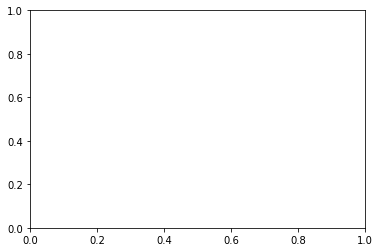

In [159]:
max_plot_degree=100
plt.figure()
print(_lambdas[_lambda_best])
for i in range(_lambda_best-10,_lambda_best+21,10):
    plt.plot(degrees[:max_plot_degree],MSE_RIDGE[i][:max_plot_degree],label='l = {}'.format(_lambdas[i]))
    if i == _lambda_best:
        plt.plot(degrees[:max_plot_degree],MSE_RIDGE[i][:max_plot_degree],'ko',label='l = {}'.format(_lambdas[i]))

plt.legend()
plt.ylabel('MSE')
plt.xlabel('Polynomial degree')
plt.xticks(degrees)
plt.title('MSE as function of polynomial degree for various l')
plt.show()

# lambdas for lasso

In [164]:
#Create random variables/predictors
N = 15 #number of points along x and y axes
n=10

# sort this for meshgrid
x = np.sort(np.random.uniform(0,1,N))
y = np.sort(np.random.uniform(0,1,N))
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1 #might wanna make a function for this to loop over weights?
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_noise = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_noise)

#number of folds for crossvalidation
k=5

#polydegrees to run
degrees=np.arange(1,6)

nlambdas = 50
_lambdas = np.logspace(-6, -3, nlambdas)
#test vals
mse_ridge_test=[]
r2_ridge_test=[]

#train vals
mse_ridge_train=[]
r2_ridge_train=[]
mse_min=100000.
MSE_LASSO = np.zeros((len(_lambdas),len(degrees)))
for i,_lambda in enumerate(_lambdas): 
    for j,deg in enumerate(degrees):
        X = Model(x,y,deg)
        X_s = X
        z_n_s = z_n


        mse_te,mse_tr,r2_te,r2_tr,betas,beta_variances  = kFolds(X_s,z_n_s,k,_lambda,'LASSO',noise_weight)
        MSE_LASSO[i][j] = mse_te
        if mse_te < mse_min:
            mse_min=mse_te
            _lambda_best = i
            _degree_best = j
print(mse_min,_lambdas[_lambda_best],degrees[_degree_best])

[0.0139176] 1.4563484775012445e-05 5


1.325711365590108e-06


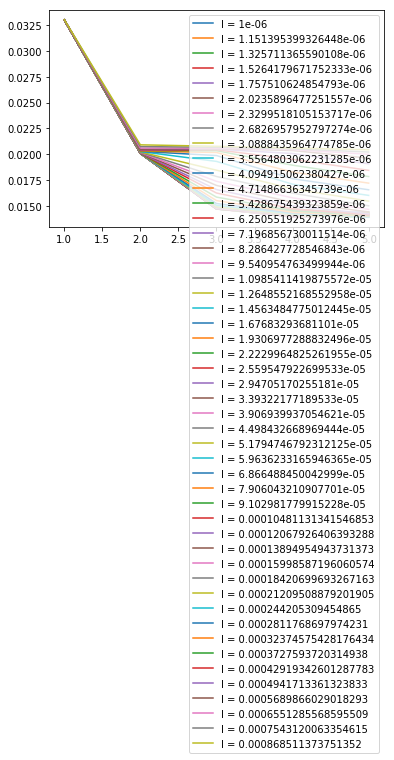

In [165]:
print(_lambdas[2])

max_plot_degree=10
plt.figure()
for i in range(len(_lambdas)-1):
    plt.plot(degrees[:max_plot_degree],MSE_LASSO[i][:max_plot_degree],label='l = {}'.format(_lambdas[i]))
plt.legend()
plt.show()

# Do stuff with the code!

In [17]:
terrain = imread('SRTM_data_Norway_1.tif')
N_p = 100 #number of pixels in in each direction
start_x = 0
start_y = 0
stop_x = start_x+N_p
stop_y = start_y + N_p

terr_square = terrain[start_x:stop_x,start_y:stop_y]

/home/janfki/anaconda3/lib/python3.7/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/janfki/anaconda3/lib/python3.7/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/janfki/anaconda3/lib/python3.7/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/janfki/anaconda3/lib/python3.7/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


In [18]:
terra = np.matrix.flatten(terr_square)
# x = np.linspace(0,len(terr_square[0]),100)
# y = np.linspace(0,len(terr_square[1]),100)
x_grid = np.linspace(0,1,N_p)
y_grid = np.linspace(0,1,N_p)
x_terr, y_terr = np.meshgrid(x_grid,y_grid,sparse=False)
k=5

In [19]:
X = Model(x_terr,y_terr,5)

In [20]:
NoResampling(X,terra,0.)[1]

NameError: name 'z_tilde' is not defined

In [402]:
mpd = 6
noise_weight_terrain=0.
mse_values_terr_test=np.zeros(mpd)
r2_values_terr_test=np.zeros(mpd)
for i in range(mpd):
    print("Currently working on polynomial degree {}".format(i+1))
    X_terr = Model(x_terr,y_terr,i+1)
    mse_values_terr_test[i] = kFolds(X_terr,terra,k,_lambda,'ols',noise_weight_terrain)[0]
    r2_values_terr_test[i] = kFolds(X_terr,terra,k,_lambda,'ols',noise_weight_terrain)[2]

Currently working on polynomial degree 1
Currently working on polynomial degree 2
Currently working on polynomial degree 3
Currently working on polynomial degree 4
Currently working on polynomial degree 5
Currently working on polynomial degree 6


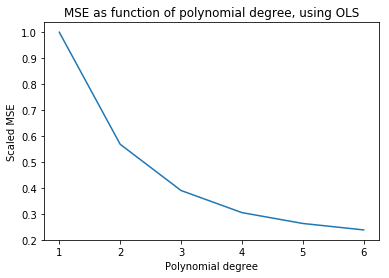

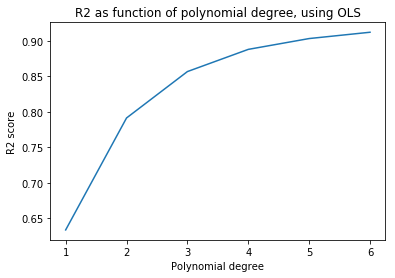

In [409]:
plt.figure()
plt.plot(np.arange(1,mpd+1),mse_values_terr_test/(max(mse_values_terr_test)))
plt.xlabel('Polynomial degree')
plt.ylabel('Scaled MSE')
plt.title('MSE as function of polynomial degree, using OLS')
plt.show()

plt.figure()
plt.plot(np.arange(1,mpd+1),r2_values_terr_test)
plt.xlabel('Polynomial degree')
plt.ylabel('R2 score')
plt.title('R2 as function of polynomial degree, using OLS')
plt.show()

In [23]:
#     this line stops you from running this cell
nlambdas = 10
_lambdas = np.logspace(-5, 0, nlambdas)

mpd = np.arange(1,11)
noise_weight_terrain=0.
mse_values_terr_test_ridge=np.zeros((len(_lambdas),len(mpd)))
mse_min_terra_ridge = 10**9
for j,deg in enumerate(mpd):
    X_terr = Model(x_terr,y_terr,deg)

    for i,_lambda in enumerate(_lambdas):
        print("Currently working on polynomial degree {}, and lambda {}".format(j+1,i))
        mse_values_terr_test_ridge[i][j] = kFolds(X_terr,terra,k,_lambda,'ridge',noise_weight_terrain)[0]
        mse_here =  mse_values_terr_test_ridge[i][j]
        if mse_here < mse_min_terra_ridge:
            mse_min_terra_ridge=mse_here
            _lambda_best_terr_ridge = i
            _degree_best_terr_ridge = j

Currently working on polynomial degree 1, and lambda 0


KeyboardInterrupt: 

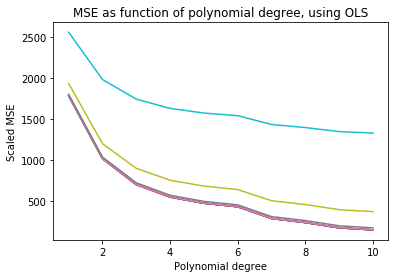

[0.0139176]


NameError: name '_lambda_best_terr_ridge' is not defined

In [433]:
plt.figure()
for i in range(len(mse_values_terr_test_ridge[0])):

    plt.plot(mpd,mse_values_terr_test_ridge[i])#/(max(mse_values_terr_test_ridge)))
plt.xlabel('Polynomial degree')
plt.ylabel('Scaled MSE')
plt.title('MSE as function of polynomial degree, using OLS')
plt.show()
print(mse_min)
print(_lambda_best_terr_ridge,_lambdas[_lambda_best_terr_ridge])
print(_degree_best_terr_ridge,mpd[_degree_best_terr_ridge])

In [ ]:
   #MAKE THIS LASSO
#     this line stops you from running this cell
nlambdas = 10
_lambdas = np.logspace(-5, 0, nlambdas)

mpd = np.arange(1,11)
noise_weight_terrain=0.
mse_values_terr_test_lasso=np.zeros((len(_lambdas),len(mpd)))
mse_min_terra_lasso = 10**9
for j,deg in enumerate(mpd):
    X_terr = Model(x_terr,y_terr,deg)

    for i,_lambda in enumerate(_lambdas):
        print("Currently working on polynomial degree {}, and lambda {}".format(j+1,i))
        mse_values_terr_test_lasso[i][j] = kFolds(X_terr,terra,k,_lambda,'LASSO',noise_weight_terrain)[0]
        mse_here =  mse_values_terr_test_lasso[i][j]
        if mse_here < mse_min_terra_lasso:
            mse_min_lasso=mse_here
            _lambda_best_terr_lasso = i
            _degree_best_terr_lasso = j

Currently working on polynomial degree 1, and lambda 0
Currently working on polynomial degree 1, and lambda 1
Currently working on polynomial degree 1, and lambda 2
Currently working on polynomial degree 1, and lambda 3
Currently working on polynomial degree 1, and lambda 4
Currently working on polynomial degree 1, and lambda 5
Currently working on polynomial degree 1, and lambda 6
Currently working on polynomial degree 1, and lambda 7
Currently working on polynomial degree 1, and lambda 8
Currently working on polynomial degree 1, and lambda 9
Currently working on polynomial degree 2, and lambda 0
Currently working on polynomial degree 2, and lambda 1
Currently working on polynomial degree 2, and lambda 2
Currently working on polynomial degree 2, and lambda 3
Currently working on polynomial degree 2, and lambda 4
Currently working on polynomial degree 2, and lambda 5
Currently working on polynomial degree 2, and lambda 6
Currently working on polynomial degree 2, and lambda 7
Currently 

/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

Currently working on polynomial degree 5, and lambda 1


/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

Currently working on polynomial degree 5, and lambda 2


/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

Currently working on polynomial degree 5, and lambda 3


/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

Currently working on polynomial degree 5, and lambda 4
Currently working on polynomial degree 5, and lambda 5
Currently working on polynomial degree 5, and lambda 6
Currently working on polynomial degree 5, and lambda 7
Currently working on polynomial degree 5, and lambda 8
Currently working on polynomial degree 5, and lambda 9
Currently working on polynomial degree 6, and lambda 0


/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

Currently working on polynomial degree 6, and lambda 1


/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

Currently working on polynomial degree 6, and lambda 2


/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

Currently working on polynomial degree 6, and lambda 3


/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

Currently working on polynomial degree 6, and lambda 4
Currently working on polynomial degree 6, and lambda 5
Currently working on polynomial degree 6, and lambda 6
Currently working on polynomial degree 6, and lambda 7
Currently working on polynomial degree 6, and lambda 8
Currently working on polynomial degree 6, and lambda 9
Currently working on polynomial degree 7, and lambda 0


/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

Currently working on polynomial degree 7, and lambda 1


/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/janfki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not co

In [ ]:
plt.figure()
maximum = np.max(mse_values_terr_test_lasso)
print(maximum)
for i in range(len(mse_values_terr_test_lasso[0])):

    plt.plot(mpd,mse_values_terr_test_lasso[i]/maximum)
plt.xlabel('Polynomial degree')
plt.ylabel('Scaled MSE')
plt.title('MSE as function of polynomial degree, using OLS')
plt.show()
print(mse_min_lasso)
print(_lambda_best_terr_lasso,_lambdas[_lambda_best_terr_lasso])
print(_degree_best_terr_lasso,mpd[_degree_best_terr_lasso])